# The Product Pricer

A model that can estimate how much something costs, from its description.

## Data Curation

We begin by scrubbing and curating our dataset by focusing on a subset of the data: Home Appliances.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [2]:
# imports
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


### One more import: Item Class
to clean, curate a datapoint of a Product with a Price

In [5]:
from items import Item

In [6]:
%matplotlib inline

In [7]:
# Load in our dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'McAuley-Lab/Amazon-Reviews-2023' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
Using the latest cached version of the dataset since McAuley-Lab/Amazon-Reviews-2023 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'raw_meta_Appliances' at /Users/marylinemajiade/.cache/huggingface/datasets/McAuley-Lab___amazon-reviews-2023/raw_meta_Appliances/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8 (last modified on Wed Aug 27 10:00:30 2025).


In [8]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [9]:
# Investigate a particular datapoint
datapoint = dataset[2]

In [10]:
# Investigate

print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [11]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [12]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

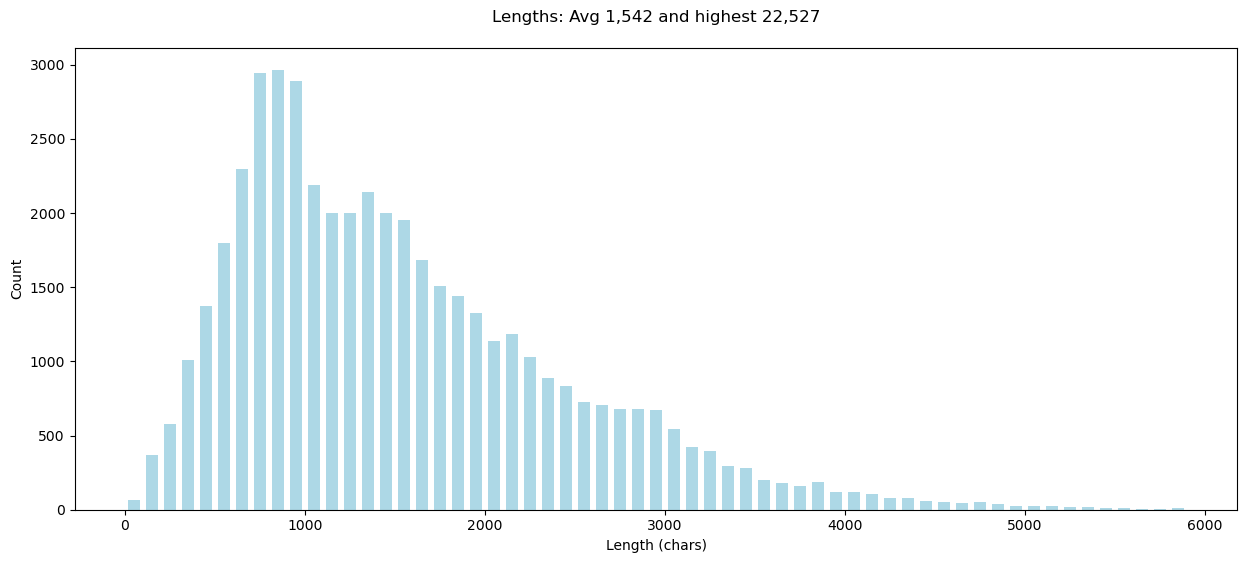

In [13]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

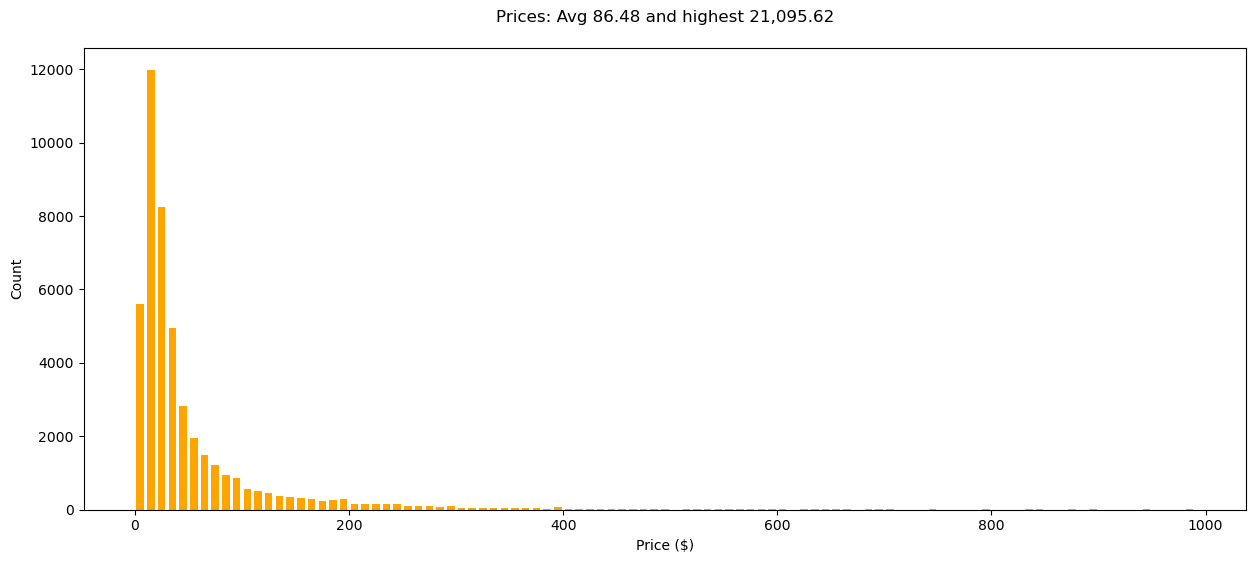

In [14]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [ ]:
#what is the most expensive item?

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

## Dataset curation part 1.2

We select items that cost between 1 and 999 USD

We will be create Item instances, which truncate the text (title, description, features, details) to fit within 180 tokens using the right Tokenizer

And will create a prompt to be used during Training.

Items will be rejected if they don't have sufficient characters.

### Hyperparameter: 180 tokens
We want a sufficiently large number of tokens so that we have enough useful information to gauge the price. But we also want to keep the number low so that we can train efficiently. And at inference time, we'll want to provide new products and have the model estimate a price. And we'll be using short descriptions of products, like 1-2 sentences. For best performance, we should size our training data to be similar to the inputs we will provide at inference time.

## 160 tokens:
The description of the products is limited to 160 tokens because we add some more text before and after the description to turn it into a prompt. That brings it to around 180 tokens in total.

In [15]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,191 items


In [16]:
# Look at the first item

items[1]

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [17]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[100].prompt)

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $118.00


In [18]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[100].test_prompt())

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $


In [ ]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

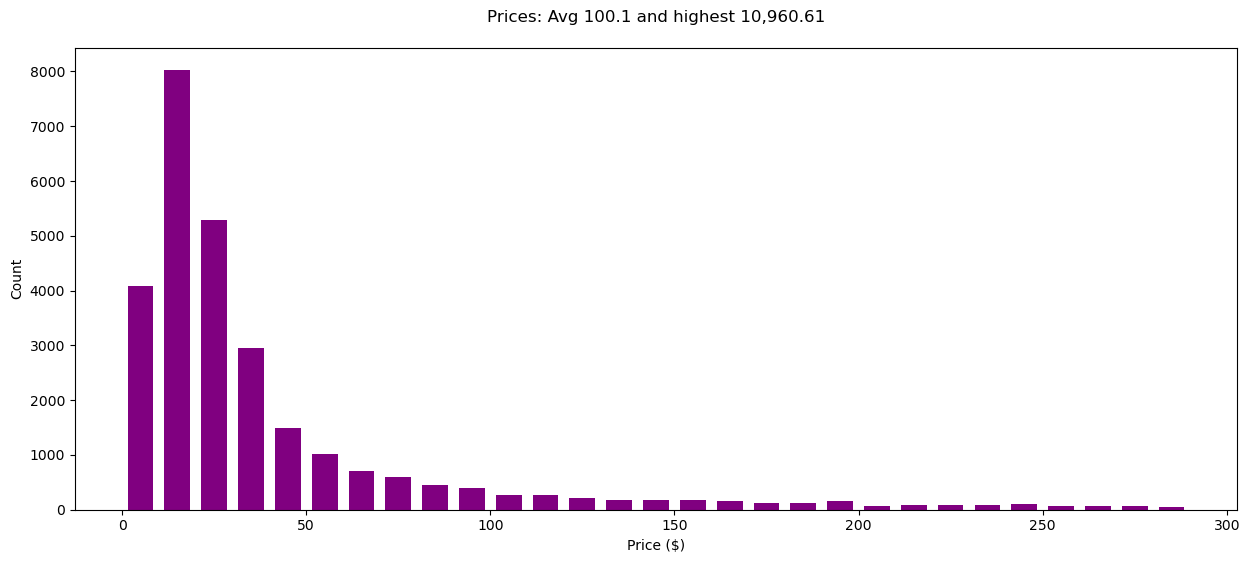

In [19]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

## Data Curation Part 2

In [20]:
# imports
import random
from collections import Counter, defaultdict
import numpy as np
import pickle

In [21]:
from items import Item
from loaders import ItemLoader
%matplotlib inline

### The ItemLoader code

Look in loaders.py - there's some useful code to make life easier for us

### Now to SCALE UP
all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [22]:
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    #"Musical_Instruments"
]

In [23]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())
print(f"A grand total of {len(items):,} items")

Loading dataset Appliances


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'McAuley-Lab/Amazon-Reviews-2023' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
Using the latest cached version of the dataset since McAuley-Lab/Amazon-Reviews-2023 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'raw_meta_Appliances' at /Users/marylinemajiade/.cache/huggingface/datasets/McAuley-Lab___amazon-reviews-2023/raw_meta_Appliances/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8 (last modified on Wed Aug 27 10:00:30 2025).
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly

Completed Appliances with 28,625 datapoints in 0.9 mins
A grand total of 28,625 items


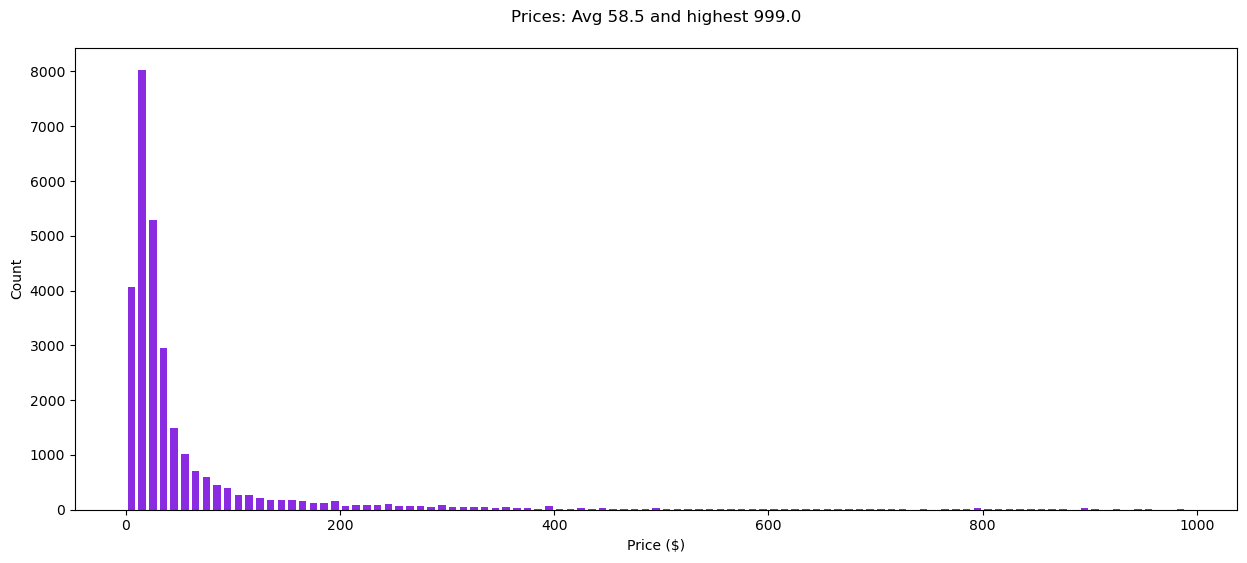

In [24]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()


### Dataset Curated!

We've crafted an excellent dataset. Let's do some final checks

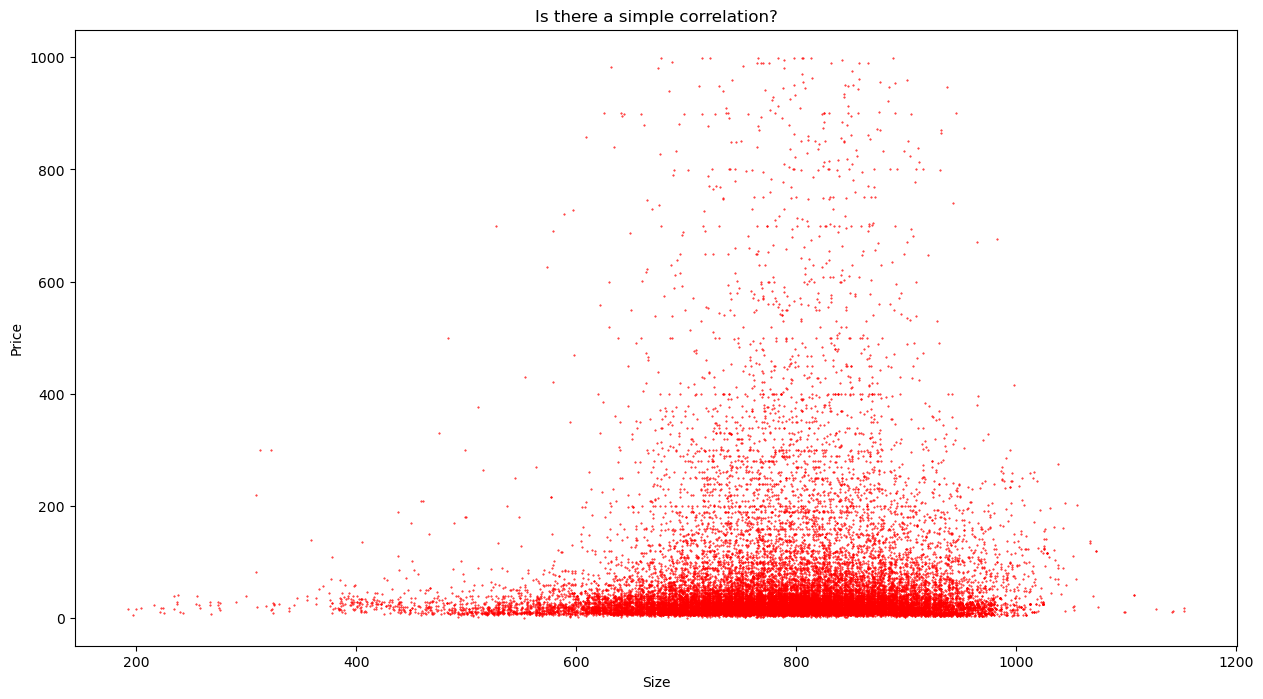

How much does this cost to the nearest dollar?

285746 OR 285811 Washer Agitator Support And Dogs Compatible with Inglis, Whirlpool, Kenmore, Roper, Admiral
285746 OR 285811 Agitator support and dogs Washing machine agitator repair kit with a medium length cam Agitator support and dogs for two piece agitators.This kit should be used when the top part of the agitator is not moving properly but the bottom part is. Replaces Old Numbers 2744 285746 285811 Washer Agitator Repair Kit. This part works with the following brands Whirlpool, Roper, Admiral, Maytag, Hardwick, Jenn-Air, Estate, Magic Chef, Crosley, Inglis, Norge, Modern Maid, Amana, Kenmore

Price is $8.00
[11, 14594, 6518, 271, 7117, 374, 400, 23, 13, 410]
[',', ' Ken', 'more', '\n\n', 'Price', ' is', ' $', '8', '.', '00']


In [25]:
# How does the price vary with the character count of the prompt?

sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))
report(sample[50])

In [26]:
# Break down our data into a training, test and validation dataset.

random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")
print(train[0].prompt)
print(test[0].test_prompt())

Divided into a training set of 25,000 items and test set of 2,000 items
How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00
How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power an

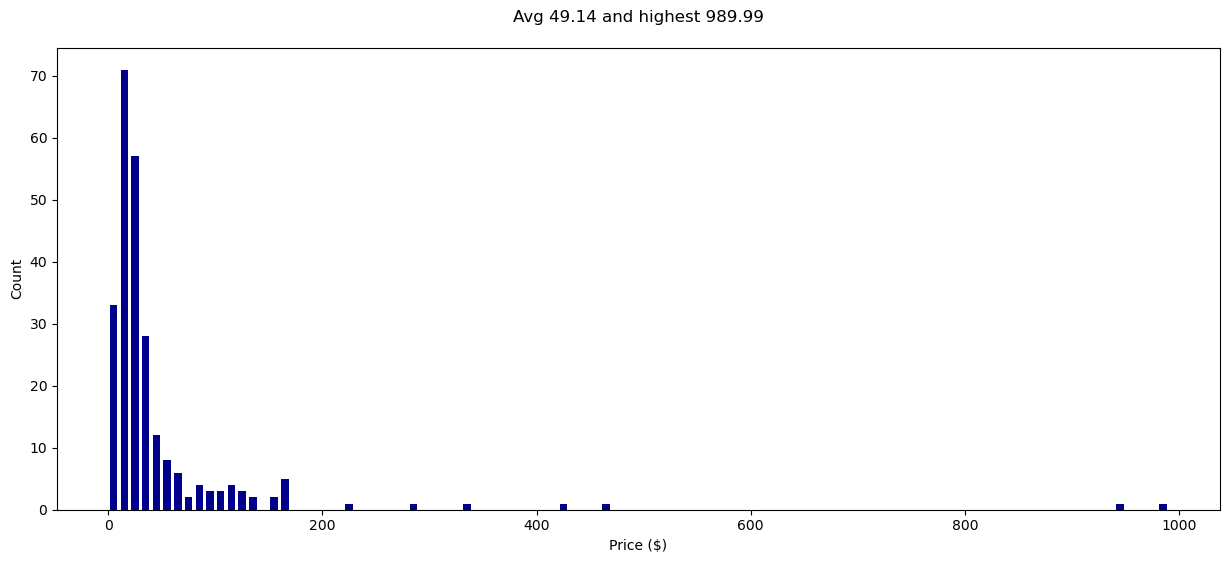

In [27]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

### Finally - upload our brand new dataset

In [28]:
#Convert to prompts and upload to HuggingFace hub
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [29]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})
DATASET_NAME = "Madie9955/lite-pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/Madie9955/lite-pricer-data/commit/cce37b644e1ffde9f8a5eb763be28dc6dbfa46a3', commit_message='Upload dataset', commit_description='', oid='cce37b644e1ffde9f8a5eb763be28dc6dbfa46a3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Madie9955/lite-pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Madie9955/lite-pricer-data'), pr_revision=None, pr_num=None)

In [30]:
#Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)

# Fine-tuning

In [33]:
# imports
import re
import math
import json
import random
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic
import wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
from items import Item
from testing import Tester
openai = OpenAI()
%matplotlib inline

In [35]:
# Load in the pickle files:

with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [36]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

### Step 1: 
Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [ ]:
# First we work on a good prompt for the model
# Remove the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nand Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)\nContents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil'},
 {'role': 'assistant', 'content': 'Price is $11.99'}]

In [38]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nand Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)\nContents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil"}, {"role": "assistant", "content": "Price is $11.99"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {

In [39]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [40]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [41]:
with open("fine_tune_train.jsonl", "rb") as f: #read binary
    train_file = openai.files.create(file=f, purpose="fine-tune")
train_file

FileObject(id='file-4QPXGM6Z7NgqFBbtrN77Hk', bytes=194105, created_at=1756292232, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [42]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")
validation_file

FileObject(id='file-Kwkxcs5EU1KNn5MH5QshWQ', bytes=48121, created_at=1756292235, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

### Step 2: Weights and Biases 
a beautiful, free platform for monitoring training runs.  
Weights and Biases is integrated with OpenAI for fine-tuning.
https://wandb.ai

In [51]:
# Fine-tune
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}
train_file.id

'file-4QPXGM6Z7NgqFBbtrN77Hk'

In [50]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-kv4gut8n7ILLzt221qYe5loN', created_at=1756292486, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-vaAnNVJOfqRgG3u73UqQlRAR', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-4QPXGM6Z7NgqFBbtrN77Hk', validation_file='file-Kwkxcs5EU1KNn5MH5QshWQ', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-kv4gut8n7ILLzt221qYe5loN'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='price

In [45]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-J7bBnK4FwkvquPArFBaoCSPI', created_at=1756292249, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-vaAnNVJOfqRgG3u73UqQlRAR', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-4QPXGM6Z7NgqFBbtrN77Hk', validation_file='file-Kwkxcs5EU1KNn5MH5QshWQ', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-J7bBnK4FwkvquPArFBaoCSPI'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epoc

In [46]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id
job_id

'ftjob-J7bBnK4FwkvquPArFBaoCSPI'

In [47]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-J7bBnK4FwkvquPArFBaoCSPI', created_at=1756292249, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-vaAnNVJOfqRgG3u73UqQlRAR', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-4QPXGM6Z7NgqFBbtrN77Hk', validation_file='file-Kwkxcs5EU1KNn5MH5QshWQ', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-J7bBnK4FwkvquPArFBaoCSPI'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='price

In [58]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-DK6dIcQdOMv41mO7ME36rR43', created_at=1756295836, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-hfa0Q0oLxJVtQHWaBCjle9Fk', created_at=1756295831, level='info', message='Usage policy evaluations completed, model is now enabled for sampling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-8b7O5XumNtxFWB8w6yixToow', created_at=1756295831, level='info', message='Moderation checks for snapshot ft:gpt-4o-mini-2024-07-18:personal:pricer:C98huS57 passed.', object='fine_tuning.job.event', data={'blocked': False, 'results': [{'flagged': False, 'category': 'harassment/threatening', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual/minors', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'propaganda', 'enforcement': 'blocking'

### Step 3: Test our fine tuned model

In [60]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:C98huS57'

In [61]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [62]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color"

In [63]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0
get_price("The price is roughly $99.99 because blah blah")

99.99

In [64]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [72]:
print(test[199].price)

8.39


In [71]:
print(gpt_fine_tuned(test[199]))

10.99


1: Guess: $10.99 Truth: $65.99 Error: $55.00 SLE: 2.96 Item: Setpower Insulated Protective Cover for ...
2: Guess: $5.99 Truth: $9.68 Error: $3.69 SLE: 0.18 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $98.99 Truth: $155.98 Error: $56.99 SLE: 0.20 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $7.47 Truth: $5.59 Error: $1.88 SLE: 0.06 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $47.22 Truth: $98.40 Error: $51.18 SLE: 0.52 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $30.47 Truth: $54.99 Error: $24.52 SLE: 0.33 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $11.98 Truth: $5.71 Error: $6.27 SLE: 0.44 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $14.65 Truth: $9.53 Error: $5.12 SLE: 0.16 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $19.99 Truth: $11.24 Error: $8.75 SLE: 0.29 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $14.98 Truth: $12.88 Error: $2.10 SLE: 0.02 Item: Away NV350 NV351

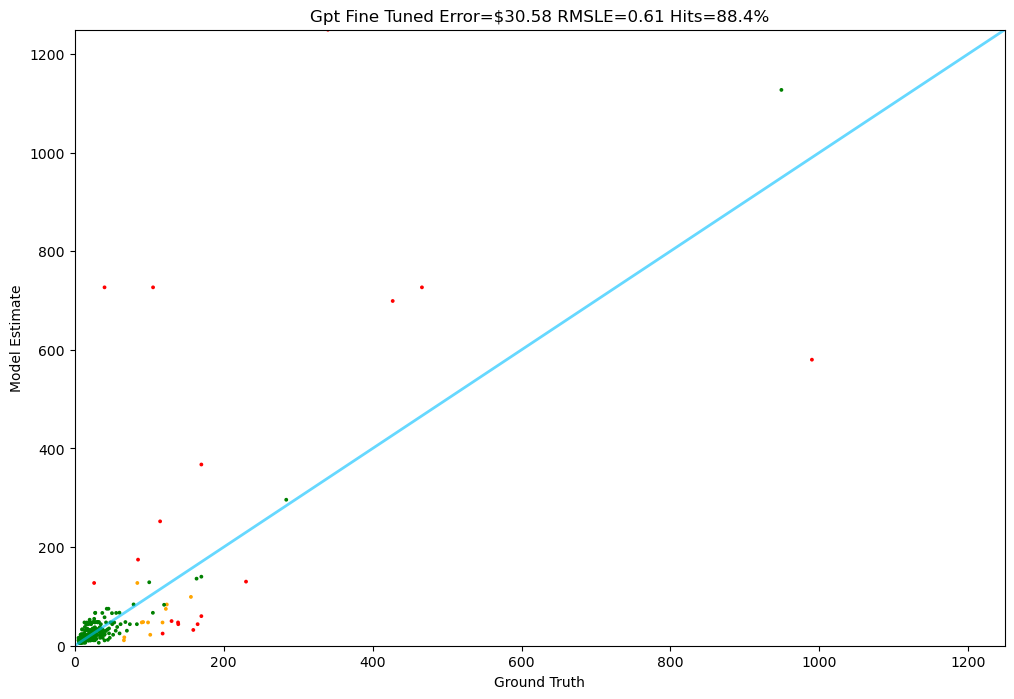

In [68]:
Tester.test(gpt_fine_tuned, test)